In [1]:
from IPython.display import display
from IPython.display import HTML
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
HTML('''<script>
code_show=true;

function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

<div id="background-img-logo-university" class="background-img-top-left" >
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4e/Universit%C3%A4t_Leipzig_logo.svg/640px-Universit%C3%A4t_Leipzig_logo.svg.png" style="width: 300px;">
</div>

<br> 
# Validity & Fairness in Machine Learning
### Analysing COVID-19 Data

<br>Leipzig, 09.09.2020
<br>Christopher Akiki, Alina Mailach, Fabian Dannegger
<br>Tutor: Prof. Dr. Norbert Siegmund
<br>Module: Aktuelle Trends in Data Science





# Agenda
<br>

- Validity - COVID-19 & Mobility
    - Introduction/ Motivation
    - Presentation of the Project
    - Analysis
- (Un-)Fairness in Machine Learning
    - Introduction/ Context
    - Mitigation
    - (MEPS notebook)


# Presentation-Notes

### Plan
- Motivation & Hypothesis
- Exploring the Data
- How we solved the problem
- Interpretation & Advice
- Discussion
<br>

- Build a setting: imagine the following scenario: hired from … to find leading factors for the spread of COVID-19/ evaluate possible political actions
- Motivation & hypothesis: 
    - Super-Spreading Events, American government wants to distribute vaccine? -> headlines 
    - second wave – how can we avoid the numbers go up again?? -> restrict mobility; mobility leading factor for infections, display it with multi-spreading events (headlines), Heatmap of cases in Germany
- Searched for Data… description/statistics of the data – why take this data for our setting/problem 
- […] (our Solution, Methology/ learning approach, Training, blabla; fake last slide with prognosis, interpretation, suggestions -> would you follow the advice?
- Discussion 
- Re-Analysis, Issues
- Summary: how to do it, gold standard// similar flawed analysis on google & twitter
<br>
Don't forget the Sildes Page numbers!

https://www.markroepke.me/posts/2019/06/05/tips-for-slideshows-in-jupyter.html

# Markdown
- **[markdown.de](markdown.de)**: Markdown: Syntax
- **[GitHub Guides](https://guides.github.com/features/mastering-markdown/)**: Mastering Markdown
- **[Baron Schwartz](https://www.xaprb.com/blog/how-to-style-images-with-markdown/)**: How to Style Images With Markdown


# Validity
<br>

>Validity determines whether the research truly measures that which it was intended to
>measure or how truthful the research results are. In other words, does the research
>instrument allow you to hit "the bull’s eye" of your research object?  
>[Joppe 2000]
<br>

- go have a look at the lecture
> Validity and Fairness in Machine Learning: A Software Engineering Perspective [Siegmund 2020]
- to sum up the most important parts:
    - interal validity: e.g. Data Splitting, Measurement Bias
    - external validity: e.g. Overfitting, Generalization Error


# COVID-19: Rising numbers worldwide

In [4]:
display( HTML('''<div class="flourish-embed flourish-bar-chart-race" data-src="visualisation/1651020"><script src="https://public.flourish.studio/resources/embed.js"></script></div>''' ))

# COVID-19

## Heatmap

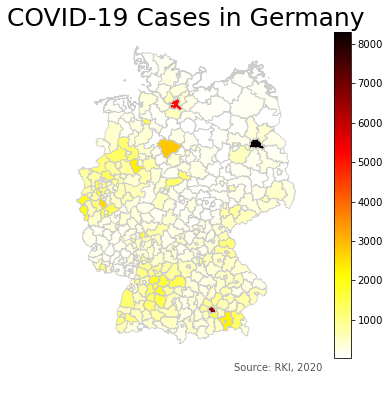

In [3]:
# load libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd


#Data:
# read shapefile from: https://public.opendatasoft.com/explore/dataset/landkreise-in-germany/export/
german_bl_shape = gpd.read_file("https://public.opendatasoft.com/explore/dataset/landkreise-in-germany/download/?format=shp&timezone=Europe/Berlin&lang=en")
# load in new csv file
rki = pd.read_csv("../data/RKI_COVID19.csv")

#sum up cases into one dataframe
cases_per_lk =pd.DataFrame(rki.groupby([rki.Landkreis,rki.IdLandkreis,rki.Bundesland,rki.IdBundesland]).apply(lambda subf: subf['AnzahlFall'].sum())).reset_index()
cases_per_lk = cases_per_lk.rename(columns={0:'Fallzahlen'}) 
#add/edit missing LKs
cases_per_lk['IdLandkreis'] = cases_per_lk['IdLandkreis'].replace(3159,3152)
osterode_am_harz = {'IdLandkreis': 3156,'Landkreis':'LK Göttingen', 'Bundesland':'Niedersachsen', 'IdBundesland': 3.0, 'Fallzahlen':1260}
cases_per_lk=cases_per_lk.append(osterode_am_harz, ignore_index=True)
berlin = {'IdLandkreis': 11000,'Landkreis':'LK Berlin', 'Bundesland':'Berlin', 'IdBundesland': 11.0, 'Fallzahlen':8300}
cases_per_lk=cases_per_lk.append(berlin, ignore_index=True)
#modify join parameter
german_bl_shape = german_bl_shape[german_bl_shape['cca_2'].notna()]
german_bl_shape['cca_2'] = german_bl_shape['cca_2'].astype(int)

#merge datasets
merged = german_bl_shape.set_index('cca_2').join(cases_per_lk.set_index('IdLandkreis'))
merged = merged.rename(columns={0:'Fallzahlen'})


#Map:
# set a variable that will call whatever column we want to visualise on the map
variable = 'Fallzahlen'
# set the range for the choropleth
vmin, vmax = 19, 8300
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))
# create map
#  for different Colormaps(cmap) check out: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
merged.plot(column=variable, cmap='hot_r', linewidth=0.8, ax=ax, edgecolor='0.8')
# Now we can customise and add annotations
# remove the axis
ax.axis('off')
# add a title
ax.set_title('COVID-19 Cases in Germany', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})
# create an annotation for the  data source
ax.annotate('Source: RKI, 2020',
           xy=(0.6, .08), xycoords='figure fraction',
           horizontalalignment='left', verticalalignment='top',
           fontsize=10, color='#555555')
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='hot_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

# Heatmap


- **[Benjamin Cooley](https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d)**: Let's make a map! [GitHub](https://github.com/bendoesdata/make-a-map-geopandas/blob/master/Let's%20make%20a%20map!%20Geopandas%20and%20Matplotlib.ipynb)
    - geopandas, pandas, numpy, matplotlib.pyplot
- **[Dr. Juan Camilo Orduz](https://juanitorduz.github.io/germany_plots/)**: Open Data- Germany Maps Viz
    - geopandas, pandas, numpy, matplotlib.pyplot
- **[Geodose](https://www.geodose.com/2020/02/tracking-coronavirus-python-map.html)**: Interactive Coronavirus Spreading Map in Python
    - plotly.offline, plotly.graph_objects, pandas
- **[Google Fusion Tables](https://support.google.com/fusiontables/answer/2527132?hl=en)**: Create: a map
- **[pyGeoDb](https://pypi.org/project/pyGeoDb/)**: It is all about Austrian, German and Swiss *postcodes (ZIPs) and city locations*. documentation is in German language.
- **[COVID-19 Tracking Germany](https://www.kaggle.com/headsortails/covid19-tracking-germany)**: Kaggle Project with heatmap [associated blogpost](https://heads0rtai1s.github.io/2020/04/30/animate-map-covid/) **!!! in R !!!**

# Setting

- Imagine the following scenario:
<br>

    - You are a data scientist in Germany
    - The RKI or Bundesregierung contacts you with the following questions:
        >What should we do about COVID-19? <br>
        >How can we stop it from infecting Germany?
    
    - Can you give them some advice?


<div id="background-img-programmer" class="background-img-bottom-right" >
    <img src="https://png2.cleanpng.com/sh/57d2405960afb86ca19eda680fb97f3e/L0KzQYm3V8AzN5RueZH0aYP2gLBuTgBzd5h3ed92ZYKwc7F0kQV1baMyiOR4Z4Lkfb7wjvcudJZmitDybnewc73wkL1ieqUyTdQ8OXO2dYe7gfM2a2YzTKoAMEmzSYe4VcMxPWI3S6cDM0C5Q3B3jvc=/kisspng-programmer-computer-programming-learning-clip-art-5b39c3e64ac5c5.4850909615305123583063.png" style="width: 300px;">
</div>

<div id="background-img-rki" class="background-img-top-right" >
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/RKI-Logo.svg/640px-RKI-Logo.svg.png" style="width: 300px;">
</div>

<div id="background-img-bundesregierung" class="background-img-top-right2" >
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4f/Die_Bundesregierung_Logo.svg/640px-Die_Bundesregierung_Logo.svg.png" style="width: 350px;">
</div>

# COVID-19 & Mobility
## Do you remember Ischgl?
<br>

<div id="headlines-ischgl" >
    <img src="../images/headlines_ischgl/CNN_Ischgl_helped_spread_across_Europe_edit.png">
    <br>
    <img src="../images/headlines_ischgl/Euractiv_Ischgl_Hotspot_edit.png">
    <br>
    <img src="../images/headlines_ischgl/Der_Spiegel_Chronicle_of_Failure_Ischgl_edit.png">
</div>

# COVID-19 & Mobility
### Hypothesis

##### Mobility is a leading factor of COVID-19 infections
<br>

### Question
##### What happens if mobility goes up again?

# COVID-19 & Mobility
## What if there are new hot spots?
<br>

<div id="headlines-second-wave" >
    <img src="../images/second_wave/Innovation_Origins_Corona_thunders_back_into_Europe_edit.png">
    <br>
    <img src="../images/second_wave/Euractiv_Mallorca_second_Ischgl_edit.png">
    <br>
    <img src="../images/second_wave/Der_Spiegel_Second_Wave_edit.png">
</div>

# Headlines

- **[Innovation Origins](https://innovationorigins.com/the-corona-chart-the-pandemic-thunders-back-into-europe-at-full-speed/)**: The Corona chart: the pandemic thunders back into Europe, at full speed
- **[The Sun](https://www.thesun.co.uk/news/12561269/spain-new-europe-hotspot-53000-coronavirus-cases-spreads-faster-than-us/)**: SPAIN PAIN Spain is new ‘Europe hotspot’ with 53,000 coronavirus cases in just a week as it spreads faster than in the US
- **[The Sun](https://www.thesun.co.uk/news/12591241/france-europe-covid-hotspot-icu-two-weeks/)**: CRITICAL POINT France becomes Europe’s coronavirus hotspot as it records highest EVER daily case figure
- **[Der Spiegel](https://www.spiegel.de/international/world/ischgl-austria-a-corona-hotspot-in-the-alps-spread-virus-across-europe-a-32b17b76-14df-4f37-bfcf-39d2ceee92ec)**: Chronicle of Failure - A Corona Hotspot in the Alps Spread Virus Across Europe
- **[Der Spiegel](https://www.spiegel.de/international/germany/the-second-wave-summer-travels-bring-rising-coronavirus-numbers-to-germany-a-69dccbaa-a5ad-4186-aac8-29e6e0428849)**: The Second Wave - Summer Travels Bring Rising Coronavirus Numbers to Germany
- **[CNN](https://edition.cnn.com/2020/03/24/europe/austria-ski-resort-ischgl-coronavirus-intl/index.html)**: How an Austrian ski resort helped coronavirus spread across Europe
- **[Euractiv](https://www.euractiv.com/section/economy-jobs/news/have-german-tourists-in-mallorca-risked-creating-a-second-ischgl-like-hotspot/)**: Have German tourists in Mallorca created a second Ischgl-like ‘hotspot’?
- **[Euractiv](https://www.euractiv.com/section/coronavirus/news/ischgl-oesterreichisches-skiparadies-als-corona-hotspot/)**: How an Austrian ski paradise became a COVID-19 hotspot